<h1>Table of Contents</h1>
<ul>
  <li><a href="#section1">1. Import Necessary Libraries</a></li>
  <li><a href="#section2">2. Load Data</a></li>
  <li><a href="#section3">3. Data Preprocessing</a></li>
  <li><a href="#section4">4. Define Model Components</a></li>
  <li><a href="#section5">5. Build and Configure Model</a></li>
  <li><a href="#section6">6. Prepare Data Sample</a></li>
  <li><a href="#section7">7. Model Fitting</a></li>
  <li><a href="#section8">8. Visualization and Analysis</a>
    <ul>
      <li><a href="#section8_1">8.1 Model Fit Diagnostics</a></li>
    </ul>
  </li>
</ul>


<a id="section1"></a>
# 1. Import Necessary Libraries

In [3]:
import os
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'  # Disable file validation for smoother execution
os.environ['PYTHONDEVMODE'] = 'off'                  # Turn off Python development mode
import pandas as pd                                  # For data manipulation and analysis
import pyddm                                         # For building and fitting diffusion decision models
from pyddm import Sample                             # To create sample objects for model fitting
import numpy as np                                   # For numerical operations
import pyddm.plot                                    # For plotting model diagnostics (imported first as required)
import matplotlib                                    # For visualization
matplotlib.use('TkAgg')                              # Set matplotlib backend to TkAgg for interactive plotting
import matplotlib.pyplot as plt                      # For creating plots
from IPython.display import Image                    # For displaying images in the notebook

<a id="section2"></a>
# 2. Load Data

In [5]:
# Load and preprocess the data
file_path = '/Users/wangyue/Desktop/data/incon_6Frame/HDDM_InconStim_6Frame.csv'
data_F = pd.read_csv(file_path)

<a id="section3"></a>
# 3. Data Preprocessing

In [7]:
# Select relevant columns for modeling and create a copy to avoid modifying the original data
data_for_model = data_F[['subj_idx', 'trial', 'rt', 'response', 'HSF_emo', 'task']].copy()
# Preserve original categorical columns for reference
data_for_model['task_original'] = data_for_model['task']        # Store original 'task' values
data_for_model['HSF_emo_original'] = data_for_model['HSF_emo']  # Store original 'HSF_emo' values
# Convert categorical variables 'task' and 'HSF_emo' into dummy variables for modeling
data_for_model = pd.get_dummies(data_for_model, columns=['task', 'HSF_emo'], prefix=['task', 'HSF_emo'])

In [8]:
# Display summary statistics of reaction times to understand their distribution
print("Summary statistics of reaction times:")
print(data_for_model['rt'].describe())  # Shows that reaction times are mostly around 2 seconds, with outliers up to ~68 seconds

Summary statistics of reaction times:
count    9750.000000
mean        0.828259
std         0.467399
min         0.010953
25%         0.584762
50%         0.714717
75%         0.909147
max         9.255789
Name: rt, dtype: float64


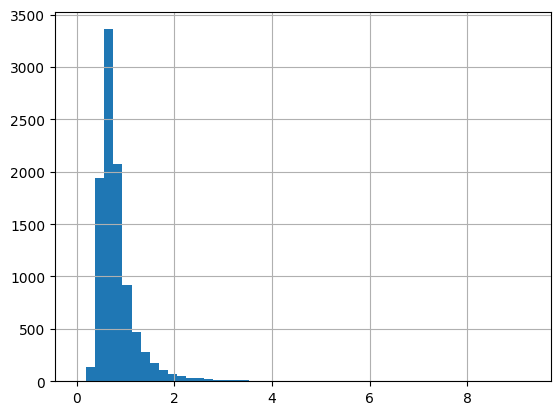

In [9]:
# Visualize the distribution of reaction times with a histogram
%matplotlib inline
data_for_model['rt'].hist(bins=50)
plt.show()

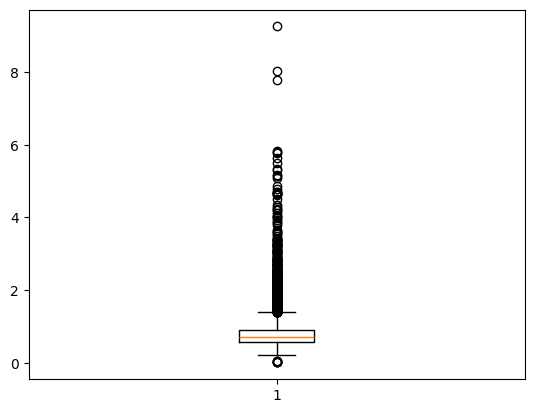

In [10]:
# Use a boxplot to visually confirm the presence of outliers in reaction times
plt.boxplot(data_for_model['rt'])
plt.show()

In [11]:
# Filter out extreme reaction times (rt >= 5 seconds) to improve model fitting
rt_threshold = 5.0
data_for_model_filtered = data_for_model[data_for_model['rt'] < rt_threshold]
print("Summary statistics of filtered reaction times:", data_for_model_filtered['rt'].describe())

Summary statistics of filtered reaction times: count    9737.000000
mean        0.821185
std         0.423111
min         0.010953
25%         0.584603
50%         0.714277
75%         0.908068
max         4.860230
Name: rt, dtype: float64


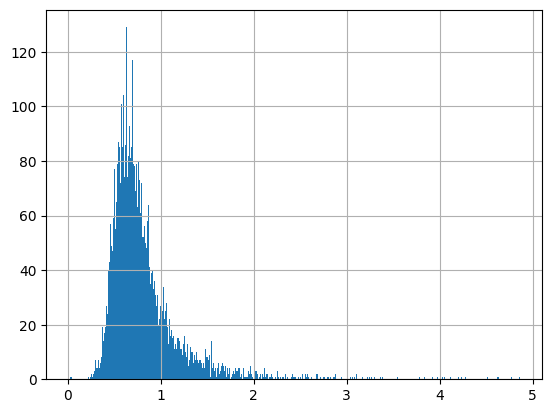

In [12]:
# Visualize the filtered reaction time distribution with a detailed histogram
%matplotlib inline
data_for_model_filtered['rt'].hist(bins=1000)
plt.show()

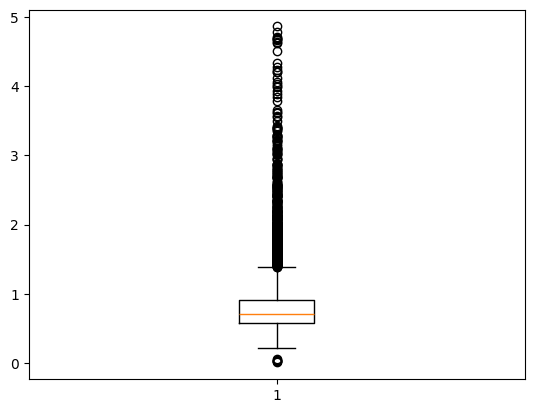

In [13]:
# Use a boxplot to check for remaining outliers in the filtered data
plt.boxplot(data_for_model_filtered['rt'])
plt.show()

<a id="section4"></a>
# 4. Define Model Components

In [15]:
# Define drift function for Model 5, dependent on both task and HSF_emo conditions
def drift_function(task_1, task_2, task_3, HSF_emo_1, HSF_emo_2, 
                  drift_task1, drift_task2, drift_task3, drift_emo1, drift_emo2, 
                  leak, t, x):
    """
    Drift rate function for Model 5, incorporating both task and HSF_emo effects.
    
    Parameters:
    - task_1, task_2, task_3: Dummy variables representing task categories.
    - HSF_emo_1, HSF_emo_2: Dummy variables representing HSF_emo conditions.
    - drift_task1, drift_task2, drift_task3: Drift parameters for each task category.
    - drift_emo1, drift_emo2: Drift parameters for each HSF_emo condition.
    - leak: Leak parameter for the integrator.
    - t: Time (not used directly but included for consistency with pyDDM).
    - x: Accumulated evidence.
    
    Returns:
    - Adjusted drift rate incorporating task, HSF_emo, and leaky integration.
    """
    # Calculate base drift rate as a linear combination of task and HSF_emo conditions
    base_drift = (drift_task1 * task_1 + drift_task2 * task_2 + drift_task3 * task_3 +
                  drift_emo1 * HSF_emo_1 + drift_emo2 * HSF_emo_2)
    
    # Apply leaky integrator to adjust drift based on accumulated evidence
    drift = base_drift - leak * x
    
    # Check for numerical stability
    if np.any(np.isnan(drift)) or np.any(np.isinf(drift)):
        print(f"Drift function error: {drift}")   
    return drift  # Return the adjusted drift rate

In [16]:
# Define bound function for Model 5, dependent on task conditions with exponential decay
def bound_function(task_1, task_2, task_3, threshold1, threshold2, threshold3, invtau, t):
    """
    Bound function with task-dependent thresholds and exponential decay.
    
    Parameters:
    - task_1, task_2, task_3: Dummy variables representing task categories (0 or 1).
    - threshold1, threshold2, threshold3: Initial threshold parameters for each task category.
    - invtau: Threshold decay rate parameter.
    - t: Time.
    
    Returns:
    - Task-dependent decision boundary that decays over time.
    """
    # Calculate base threshold by selecting the appropriate threshold parameter based on task
    base_bound = threshold1 * task_1 + threshold2 * task_2 + threshold3 * task_3
    
    # Apply time-dependent exponential decay to the threshold
    bound = base_bound * np.exp(-t * invtau)
    
    # Check for numerical stability
    if np.any(np.isnan(bound)) or np.any(np.isinf(bound)):
        print(f"Bound function error: {bound}")
    return bound

<a id="section5"></a>
# 5. Build and Configure Model

In [18]:
# Build and configure Model 5 with both task and HSF_emo dependent drift and task-dependent bound
model_5 = pyddm.gddm(
    drift=drift_function,  # Use the custom task and HSF_emo-dependent drift function
    noise=1.0,             # Fixed noise level for the diffusion process
    bound=bound_function,  # Use the custom task-dependent bound function
    nondecision="nt",      # Non-decision time parameter
    starting_position="x0",# Starting position parameter (fixed across conditions)
    parameters={
        # Drift parameters for task conditions (wide ranges to allow for positive/negative effects)
        "drift_task1": (-3, 3), "drift_task2": (-3, 3), "drift_task3": (0, 5),
        # Drift parameters for HSF_emo conditions
        "drift_emo1": (0, 2.5), "drift_emo2": (-3, 0),
        # Threshold parameters for task conditions
        "threshold1": (0.5, 1.2), "threshold2": (0.5, 1.2), "threshold3": (0.5, 1.2), 
        # Other model parameters
        "x0": (-1, 1),            # Range for starting position of evidence
        "nt": (0, 1),             # Range for non-decision time
        "leak": (0, 0.03),        # Range for leak parameter in the integrator
        "invtau": (0.1, 1)        # Range for decay rate in the bound function
    },
    conditions=["task_1", "task_2", "task_3", "HSF_emo_1", "HSF_emo_2"],  # Specify both task and HSF_emo dummy variables as conditions
    T_dur=5.0  # Simulation duration in seconds
)

<a id="section6"></a>
# 6. Prepare Data Sample

In [20]:
# Convert the filtered DataFrame into a pyDDM Sample object for model fitting
data_sample_filtered = Sample.from_pandas_dataframe(data_for_model_filtered, rt_column_name='rt', choice_column_name='response')

<a id="section7"></a>
# 7. Model Fitting

In [22]:
# Attempt to fit Model 5 to the filtered data sample using BIC loss
try:
    model_5.fit(data_sample_filtered, lossfunction=pyddm.LossBIC, verbose=True)
except Exception as e:
    print(f"Error during model fitting: {e}")  # Report any fitting errors for debugging
    print(f"Current model parameters: {model_5.parameters}")  # Display parameters if fitting fails

Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-1.060234184251898, minval=-3, maxval=3), drift_task2=Fitted(0.7261501071621541, minval=-3, maxval=3), drift_task3=Fitted(4.1618871955404, minval=0, maxval=5), drift_emo1=Fitted(0.8908318448703444, minval=0, maxval=2.5), drift_emo2=Fitted(-2.939431236004112, minval=-3, maxval=0), leak=Fitted(0.026904518824865088, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(1.0655277145460165, minval=0.5, maxval=1.2), threshold2=Fitted(0.6537396916030865, minval=0.5, maxval=1.2), threshold3=Fitted(1.138891892929784, minval=0.5, maxval=1.2), invtau=Fitted(0.4242890487826072, minval=0.1, maxval=1)), IC=ICPointRatio(x0=Fitted(-0.2526720672213949, minval=-1, maxval=1)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.23677557401278304, minval=0, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=40185.1452261093
Info: Model(name='', drift=Drift

differential_evolution step 1: f(x)= 20449.446684338578


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-2.304343023116827, minval=-3, maxval=3), drift_task2=Fitted(-0.1885788468047055, minval=-3, maxval=3), drift_task3=Fitted(3.195705062273435, minval=0, maxval=5), drift_emo1=Fitted(0.25945748457229945, minval=0, maxval=2.5), drift_emo2=Fitted(-1.6753313785067925, minval=-3, maxval=0), leak=Fitted(0.0023286724175456876, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(0.8948911450311733, minval=0.5, maxval=1.2), threshold2=Fitted(0.6015947208569129, minval=0.5, maxval=1.2), threshold3=Fitted(0.6054747650160179, minval=0.5, maxval=1.2), invtau=Fitted(0.14314676966337958, minval=0.1, maxval=1)), IC=ICPointRatio(x0=Fitted(0.0012578165187908663, minval=-1, maxval=1)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.759015788641082, minval=0, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=85563.2926553286
Info: Model(name='', dri

differential_evolution step 2: f(x)= 19101.764168212136


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(2.2299094261011527, minval=-3, maxval=3), drift_task2=Fitted(-2.6758139690368195, minval=-3, maxval=3), drift_task3=Fitted(3.195705062273435, minval=0, maxval=5), drift_emo1=Fitted(2.0969080757245466, minval=0, maxval=2.5), drift_emo2=Fitted(-1.6753313785067925, minval=-3, maxval=0), leak=Fitted(0.004051746018873368, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(0.8948911450311733, minval=0.5, maxval=1.2), threshold2=Fitted(0.6015947208569129, minval=0.5, maxval=1.2), threshold3=Fitted(1.1394441869637055, minval=0.5, maxval=1.2), invtau=Fitted(0.6210885665719271, minval=0.1, maxval=1)), IC=ICPointRatio(x0=Fitted(-0.05580390671848379, minval=-1, maxval=1)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.24977383075438497, minval=0, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=46135.46656252752
Info: Model(name='', drif

differential_evolution step 3: f(x)= 19041.991047499632


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.6463757266038453, minval=-3, maxval=3), drift_task2=Fitted(0.3851901523064123, minval=-3, maxval=3), drift_task3=Fitted(3.195705062273435, minval=0, maxval=5), drift_emo1=Fitted(1.1997015814219598, minval=0, maxval=2.5), drift_emo2=Fitted(-1.9794208834612652, minval=-3, maxval=0), leak=Fitted(0.004051746018873368, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(0.6842485375364259, minval=0.5, maxval=1.2), threshold2=Fitted(0.5806292908566097, minval=0.5, maxval=1.2), threshold3=Fitted(1.1394441869637055, minval=0.5, maxval=1.2), invtau=Fitted(0.5567788569734416, minval=0.1, maxval=1)), IC=ICPointRatio(x0=Fitted(-0.05580390671848379, minval=-1, maxval=1)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.2869324053236753, minval=0, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=31413.824276077416
Info: Model(name='', drif

differential_evolution step 4: f(x)= 17049.04599900873


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.12534685156079517, minval=-3, maxval=3), drift_task2=Fitted(0.07563241751657679, minval=-3, maxval=3), drift_task3=Fitted(2.2088439451418242, minval=0, maxval=5), drift_emo1=Fitted(2.140461130221004, minval=0, maxval=2.5), drift_emo2=Fitted(-1.5592428719865419, minval=-3, maxval=0), leak=Fitted(0.025905580974174044, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(1.1043149230592584, minval=0.5, maxval=1.2), threshold2=Fitted(0.7189864687633105, minval=0.5, maxval=1.2), threshold3=Fitted(0.7163039533639255, minval=0.5, maxval=1.2), invtau=Fitted(0.31285710065475436, minval=0.1, maxval=1)), IC=ICPointRatio(x0=Fitted(-0.3573944008221628, minval=-1, maxval=1)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.47362406218913744, minval=0, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=34641.26736296684
Info: Model(name='', dr

differential_evolution step 5: f(x)= 17049.04599900873


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.3084780211670757, minval=-3, maxval=3), drift_task2=Fitted(0.9779490081435755, minval=-3, maxval=3), drift_task3=Fitted(2.0393468082123056, minval=0, maxval=5), drift_emo1=Fitted(1.8998432097768707, minval=0, maxval=2.5), drift_emo2=Fitted(-0.42453810157149774, minval=-3, maxval=0), leak=Fitted(0.019647649180821777, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(1.1218209264969994, minval=0.5, maxval=1.2), threshold2=Fitted(0.9867309309301202, minval=0.5, maxval=1.2), threshold3=Fitted(1.0216827409869607, minval=0.5, maxval=1.2), invtau=Fitted(0.2641906868310001, minval=0.1, maxval=1)), IC=ICPointRatio(x0=Fitted(0.05528092611719293, minval=-1, maxval=1)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.2056676928419744, minval=0, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=30167.395425065402
Info: Model(name='', drif

differential_evolution step 6: f(x)= 16355.465825621852


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.2866741723570887, minval=-3, maxval=3), drift_task2=Fitted(0.6009043865719168, minval=-3, maxval=3), drift_task3=Fitted(0.6351543280408187, minval=0, maxval=5), drift_emo1=Fitted(1.4218837475030621, minval=0, maxval=2.5), drift_emo2=Fitted(-1.6785391743418228, minval=-3, maxval=0), leak=Fitted(0.01908535239109512, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(0.898821851146962, minval=0.5, maxval=1.2), threshold2=Fitted(0.5155476852616492, minval=0.5, maxval=1.2), threshold3=Fitted(1.024265487458967, minval=0.5, maxval=1.2), invtau=Fitted(0.6036299251809609, minval=0.1, maxval=1)), IC=ICPointRatio(x0=Fitted(-0.05580390671848379, minval=-1, maxval=1)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.2747670963136114, minval=0, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=24707.989112704185
Info: Model(name='', drift=D

differential_evolution step 7: f(x)= 15756.47287266645


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.39653096767949836, minval=-3, maxval=3), drift_task2=Fitted(-0.7423851454680097, minval=-3, maxval=3), drift_task3=Fitted(0.815688041251468, minval=0, maxval=5), drift_emo1=Fitted(0.9331093178138882, minval=0, maxval=2.5), drift_emo2=Fitted(-0.6689181911417749, minval=-3, maxval=0), leak=Fitted(0.02268856961073691, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(1.0249734636857146, minval=0.5, maxval=1.2), threshold2=Fitted(0.9095684419205095, minval=0.5, maxval=1.2), threshold3=Fitted(1.1394441869637055, minval=0.5, maxval=1.2), invtau=Fitted(0.9601175814729717, minval=0.1, maxval=1)), IC=ICPointRatio(x0=Fitted(-0.1391536680205353, minval=-1, maxval=1)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.2885584142768391, minval=0, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=18159.892621860658
Info: Model(name='', drift

differential_evolution step 8: f(x)= 15065.15598527309


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(1.2203614999922823, minval=-3, maxval=3), drift_task2=Fitted(-0.5817675728514659, minval=-3, maxval=3), drift_task3=Fitted(0.11207573475032806, minval=0, maxval=5), drift_emo1=Fitted(1.310857572351805, minval=0, maxval=2.5), drift_emo2=Fitted(-0.1324121628406365, minval=-3, maxval=0), leak=Fitted(0.02268856961073691, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(1.1102418641081095, minval=0.5, maxval=1.2), threshold2=Fitted(0.9095684419205095, minval=0.5, maxval=1.2), threshold3=Fitted(1.1977128988533248, minval=0.5, maxval=1.2), invtau=Fitted(0.4308112117953663, minval=0.1, maxval=1)), IC=ICPointRatio(x0=Fitted(-0.1391536680205353, minval=-1, maxval=1)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.2885584142768391, minval=0, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=18797.809263317446
Info: Model(name='', drift

differential_evolution step 9: f(x)= 15063.821705391654


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.860609814937827, minval=-3, maxval=3), drift_task2=Fitted(1.8587719753125171, minval=-3, maxval=3), drift_task3=Fitted(0.48919864302610705, minval=0, maxval=5), drift_emo1=Fitted(1.4703670304691894, minval=0, maxval=2.5), drift_emo2=Fitted(-0.6689181911417749, minval=-3, maxval=0), leak=Fitted(0.023460005404962056, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(1.0249734636857146, minval=0.5, maxval=1.2), threshold2=Fitted(0.6955654966343766, minval=0.5, maxval=1.2), threshold3=Fitted(1.003233060623027, minval=0.5, maxval=1.2), invtau=Fitted(0.613410851129195, minval=0.1, maxval=1)), IC=ICPointRatio(x0=Fitted(0.053668037842514726, minval=-1, maxval=1)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.33035093106628843, minval=0, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=22265.112632574976
Info: Model(name='', drift

differential_evolution step 10: f(x)= 15063.821705391654


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(2.2808715242515465, minval=-3, maxval=3), drift_task2=Fitted(-0.4613370533748382, minval=-3, maxval=3), drift_task3=Fitted(0.7245474574350381, minval=0, maxval=5), drift_emo1=Fitted(0.6587773085381726, minval=0, maxval=2.5), drift_emo2=Fitted(-1.0676730657472808, minval=-3, maxval=0), leak=Fitted(0.023673973522977655, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(1.171777521370731, minval=0.5, maxval=1.2), threshold2=Fitted(1.0361345215785565, minval=0.5, maxval=1.2), threshold3=Fitted(1.1458267704921647, minval=0.5, maxval=1.2), invtau=Fitted(0.7578464659234675, minval=0.1, maxval=1)), IC=ICPointRatio(x0=Fitted(-0.08651248816258783, minval=-1, maxval=1)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.2162038254984895, minval=0, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=21509.885642731362
Info: Model(name='', drif

differential_evolution step 11: f(x)= 15063.821705391654


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(1.2037106210670032, minval=-3, maxval=3), drift_task2=Fitted(-0.6709878813512336, minval=-3, maxval=3), drift_task3=Fitted(0.12122154468657387, minval=0, maxval=5), drift_emo1=Fitted(0.9290622860366127, minval=0, maxval=2.5), drift_emo2=Fitted(-0.6809602567045646, minval=-3, maxval=0), leak=Fitted(0.027954432877873768, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(1.0936725182160583, minval=0.5, maxval=1.2), threshold2=Fitted(0.8488405570881439, minval=0.5, maxval=1.2), threshold3=Fitted(1.085670965249601, minval=0.5, maxval=1.2), invtau=Fitted(0.4971268434777018, minval=0.1, maxval=1)), IC=ICPointRatio(x0=Fitted(-0.06621760904938512, minval=-1, maxval=1)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.305778855645395, minval=0, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=18239.292026369887
Info: Model(name='', drif

differential_evolution step 12: f(x)= 14829.25784775949


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.39653096767949836, minval=-3, maxval=3), drift_task2=Fitted(0.6064786501431021, minval=-3, maxval=3), drift_task3=Fitted(0.603382425345089, minval=0, maxval=5), drift_emo1=Fitted(0.46990328068813114, minval=0, maxval=2.5), drift_emo2=Fitted(-0.9712061209666671, minval=-3, maxval=0), leak=Fitted(0.02268856961073691, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(1.0921365279125526, minval=0.5, maxval=1.2), threshold2=Fitted(1.0608544654418341, minval=0.5, maxval=1.2), threshold3=Fitted(1.1323712268734485, minval=0.5, maxval=1.2), invtau=Fitted(0.7931007684403202, minval=0.1, maxval=1)), IC=ICPointRatio(x0=Fitted(0.011614684317376778, minval=-1, maxval=1)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.30946752696277624, minval=0, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15245.948148729432
Info: Model(name='', dri

differential_evolution step 13: f(x)= 14634.032716248703


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.2424318253090414, minval=-3, maxval=3), drift_task2=Fitted(0.6064786501431021, minval=-3, maxval=3), drift_task3=Fitted(0.603382425345089, minval=0, maxval=5), drift_emo1=Fitted(0.46990328068813114, minval=0, maxval=2.5), drift_emo2=Fitted(-1.131451028490277, minval=-3, maxval=0), leak=Fitted(0.015674764894851322, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(1.0921365279125526, minval=0.5, maxval=1.2), threshold2=Fitted(0.8534263315872007, minval=0.5, maxval=1.2), threshold3=Fitted(0.9021265005853143, minval=0.5, maxval=1.2), invtau=Fitted(0.7931007684403202, minval=0.1, maxval=1)), IC=ICPointRatio(x0=Fitted(-0.017185407606823078, minval=-1, maxval=1)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3231692756376844, minval=0, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15935.58115359636
Info: Model(name='', drift

differential_evolution step 14: f(x)= 14627.072488998612


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.39653096767949836, minval=-3, maxval=3), drift_task2=Fitted(0.80983191263836, minval=-3, maxval=3), drift_task3=Fitted(0.603382425345089, minval=0, maxval=5), drift_emo1=Fitted(0.3761950674971136, minval=0, maxval=2.5), drift_emo2=Fitted(-0.9712061209666671, minval=-3, maxval=0), leak=Fitted(0.0038206007235269714, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(0.7918383145945624, minval=0.5, maxval=1.2), threshold2=Fitted(0.831529911716273, minval=0.5, maxval=1.2), threshold3=Fitted(1.1323712268734485, minval=0.5, maxval=1.2), invtau=Fitted(0.28323736818070094, minval=0.1, maxval=1)), IC=ICPointRatio(x0=Fitted(0.018023232194422034, minval=-1, maxval=1)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.30946752696277624, minval=0, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15715.560688299198
Info: Model(name='', drif

differential_evolution step 15: f(x)= 14627.072488998612


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.39653096767949836, minval=-3, maxval=3), drift_task2=Fitted(0.5779446507363912, minval=-3, maxval=3), drift_task3=Fitted(0.2352951205801488, minval=0, maxval=5), drift_emo1=Fitted(0.29537643753902243, minval=0, maxval=2.5), drift_emo2=Fitted(-0.8407697421312794, minval=-3, maxval=0), leak=Fitted(0.021751445969952488, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(1.0921365279125526, minval=0.5, maxval=1.2), threshold2=Fitted(0.9744750288667621, minval=0.5, maxval=1.2), threshold3=Fitted(0.6821502089396134, minval=0.5, maxval=1.2), invtau=Fitted(0.30306754054870183, minval=0.1, maxval=1)), IC=ICPointRatio(x0=Fitted(0.13004591191476633, minval=-1, maxval=1)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.30946752696277624, minval=0, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=17025.161871968485
Info: Model(name='', d

differential_evolution step 16: f(x)= 14627.072488998612


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.1137792390927348, minval=-3, maxval=3), drift_task2=Fitted(0.2324440187120711, minval=-3, maxval=3), drift_task3=Fitted(0.7111981040481052, minval=0, maxval=5), drift_emo1=Fitted(1.3519342454059158, minval=0, maxval=2.5), drift_emo2=Fitted(-0.9712061209666671, minval=-3, maxval=0), leak=Fitted(0.028247424982632947, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(1.0921365279125526, minval=0.5, maxval=1.2), threshold2=Fitted(0.612666778177278, minval=0.5, maxval=1.2), threshold3=Fitted(0.6603047268435122, minval=0.5, maxval=1.2), invtau=Fitted(0.7931007684403202, minval=0.1, maxval=1)), IC=ICPointRatio(x0=Fitted(0.11719611014791509, minval=-1, maxval=1)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3336766351029959, minval=0, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=21777.788432071648
Info: Model(name='', drift=

differential_evolution step 17: f(x)= 14627.072488998612


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.3422894496098321, minval=-3, maxval=3), drift_task2=Fitted(0.9437298901787767, minval=-3, maxval=3), drift_task3=Fitted(0.5259485738801082, minval=0, maxval=5), drift_emo1=Fitted(0.3573363060840289, minval=0, maxval=2.5), drift_emo2=Fitted(-0.9805290994249533, minval=-3, maxval=0), leak=Fitted(0.029869184199428016, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(0.8647301898451655, minval=0.5, maxval=1.2), threshold2=Fitted(0.8146629915014031, minval=0.5, maxval=1.2), threshold3=Fitted(0.8231785698035727, minval=0.5, maxval=1.2), invtau=Fitted(0.33474574517615574, minval=0.1, maxval=1)), IC=ICPointRatio(x0=Fitted(0.0852288729373123, minval=-1, maxval=1)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.33318195014948015, minval=0, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14785.518291557499
Info: Model(name='', drif

differential_evolution step 18: f(x)= 14423.254090453633


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.60895870300824, minval=-3, maxval=3), drift_task2=Fitted(0.20064671871272033, minval=-3, maxval=3), drift_task3=Fitted(0.16018057296903354, minval=0, maxval=5), drift_emo1=Fitted(1.01978738047972, minval=0, maxval=2.5), drift_emo2=Fitted(-1.1914615899239553, minval=-3, maxval=0), leak=Fitted(0.024370333851000986, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(0.8655131988716824, minval=0.5, maxval=1.2), threshold2=Fitted(0.9280125891665167, minval=0.5, maxval=1.2), threshold3=Fitted(0.9433775520195955, minval=0.5, maxval=1.2), invtau=Fitted(0.37866571015154005, minval=0.1, maxval=1)), IC=ICPointRatio(x0=Fitted(0.048635773361136, minval=-1, maxval=1)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.32706615810812695, minval=0, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15520.600532383363
Info: Model(name='', drift=D

differential_evolution step 19: f(x)= 14423.254090453633


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.3422894496098321, minval=-3, maxval=3), drift_task2=Fitted(0.5243683002380661, minval=-3, maxval=3), drift_task3=Fitted(0.2971889957993765, minval=0, maxval=5), drift_emo1=Fitted(0.3350048250965394, minval=0, maxval=2.5), drift_emo2=Fitted(-0.9805290994249533, minval=-3, maxval=0), leak=Fitted(0.017957134148784817, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(0.8758126312352305, minval=0.5, maxval=1.2), threshold2=Fitted(0.8062668812109014, minval=0.5, maxval=1.2), threshold3=Fitted(0.8231785698035727, minval=0.5, maxval=1.2), invtau=Fitted(0.33474574517615574, minval=0.1, maxval=1)), IC=ICPointRatio(x0=Fitted(0.12023093263685292, minval=-1, maxval=1)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.29730638565352646, minval=0, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14865.216986644946
Info: Model(name='', dri

differential_evolution step 20: f(x)= 14423.254090453633


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.3217068721826002, minval=-3, maxval=3), drift_task2=Fitted(0.6776549302722341, minval=-3, maxval=3), drift_task3=Fitted(0.8873500604893674, minval=0, maxval=5), drift_emo1=Fitted(0.4320859580335703, minval=0, maxval=2.5), drift_emo2=Fitted(-0.8886074762314383, minval=-3, maxval=0), leak=Fitted(0.01902170344691065, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(0.9689741408085799, minval=0.5, maxval=1.2), threshold2=Fitted(0.9065963914149953, minval=0.5, maxval=1.2), threshold3=Fitted(0.9946459620375756, minval=0.5, maxval=1.2), invtau=Fitted(0.33474574517615574, minval=0.1, maxval=1)), IC=ICPointRatio(x0=Fitted(-0.02885668095645022, minval=-1, maxval=1)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.33318195014948015, minval=0, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15988.403445616612
Info: Model(name='', dri

differential_evolution step 21: f(x)= 14423.254090453633


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.04283881910844034, minval=-3, maxval=3), drift_task2=Fitted(0.6679408062602752, minval=-3, maxval=3), drift_task3=Fitted(0.6446129598645696, minval=0, maxval=5), drift_emo1=Fitted(0.5401116031199281, minval=0, maxval=2.5), drift_emo2=Fitted(-0.9650728178811878, minval=-3, maxval=0), leak=Fitted(0.029869184199428016, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(0.8647301898451655, minval=0.5, maxval=1.2), threshold2=Fitted(0.8233497612712539, minval=0.5, maxval=1.2), threshold3=Fitted(0.8232879108182314, minval=0.5, maxval=1.2), invtau=Fitted(0.33474574517615574, minval=0.1, maxval=1)), IC=ICPointRatio(x0=Fitted(0.0852288729373123, minval=-1, maxval=1)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3130757311211823, minval=0, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14841.567201578171
Info: Model(name='', drif

differential_evolution step 22: f(x)= 14423.254090453633


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.2588120090645276, minval=-3, maxval=3), drift_task2=Fitted(0.7170663203476779, minval=-3, maxval=3), drift_task3=Fitted(0.9087120459405345, minval=0, maxval=5), drift_emo1=Fitted(0.4460620872446539, minval=0, maxval=2.5), drift_emo2=Fitted(-0.9805290994249533, minval=-3, maxval=0), leak=Fitted(0.01652030365051351, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(0.8554212352142355, minval=0.5, maxval=1.2), threshold2=Fitted(0.8435577044081688, minval=0.5, maxval=1.2), threshold3=Fitted(0.8231785698035727, minval=0.5, maxval=1.2), invtau=Fitted(0.24243492107266523, minval=0.1, maxval=1)), IC=ICPointRatio(x0=Fitted(0.06676516956403677, minval=-1, maxval=1)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3356107836045619, minval=0, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15033.18662717603
Info: Model(name='', drift=

differential_evolution step 23: f(x)= 14423.254090453633


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.45475788050570953, minval=-3, maxval=3), drift_task2=Fitted(0.801076847636524, minval=-3, maxval=3), drift_task3=Fitted(0.5960982059559472, minval=0, maxval=5), drift_emo1=Fitted(0.02668308424131771, minval=0, maxval=2.5), drift_emo2=Fitted(-1.2542623787204021, minval=-3, maxval=0), leak=Fitted(0.02362727640500626, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(0.9589462853659693, minval=0.5, maxval=1.2), threshold2=Fitted(0.9326900706942325, minval=0.5, maxval=1.2), threshold3=Fitted(1.0641706515849814, minval=0.5, maxval=1.2), invtau=Fitted(0.5488217697413038, minval=0.1, maxval=1)), IC=ICPointRatio(x0=Fitted(0.06204213830336269, minval=-1, maxval=1)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.2768634192487903, minval=0, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14885.853969640337
Info: Model(name='', drift

differential_evolution step 24: f(x)= 14423.254090453633


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.9550319403311833, minval=-3, maxval=3), drift_task2=Fitted(0.8686712564179557, minval=-3, maxval=3), drift_task3=Fitted(0.749303911532214, minval=0, maxval=5), drift_emo1=Fitted(0.28556110771704524, minval=0, maxval=2.5), drift_emo2=Fitted(-1.4170364913068028, minval=-3, maxval=0), leak=Fitted(0.029869184199428016, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(0.8647301898451655, minval=0.5, maxval=1.2), threshold2=Fitted(1.0043579941242973, minval=0.5, maxval=1.2), threshold3=Fitted(0.8231785698035727, minval=0.5, maxval=1.2), invtau=Fitted(0.5478424486109422, minval=0.1, maxval=1)), IC=ICPointRatio(x0=Fitted(0.028301420982920655, minval=-1, maxval=1)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.33318195014948015, minval=0, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15137.157421555956
Info: Model(name='', dri

differential_evolution step 25: f(x)= 14423.254090453633


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.4863567802067408, minval=-3, maxval=3), drift_task2=Fitted(0.9437298901787767, minval=-3, maxval=3), drift_task3=Fitted(0.4087598712219225, minval=0, maxval=5), drift_emo1=Fitted(0.5613716403923819, minval=0, maxval=2.5), drift_emo2=Fitted(-0.9805290994249533, minval=-3, maxval=0), leak=Fitted(0.0297538758365979, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(0.9546219417791861, minval=0.5, maxval=1.2), threshold2=Fitted(0.9162533999916779, minval=0.5, maxval=1.2), threshold3=Fitted(1.005057474756209, minval=0.5, maxval=1.2), invtau=Fitted(0.5310258879244137, minval=0.1, maxval=1)), IC=ICPointRatio(x0=Fitted(0.03261360442191297, minval=-1, maxval=1)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.29413718503458636, minval=0, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14692.858390081812
Info: Model(name='', drift=D

differential_evolution step 26: f(x)= 14423.254090453633


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.3151167161811059, minval=-3, maxval=3), drift_task2=Fitted(0.49106042288245866, minval=-3, maxval=3), drift_task3=Fitted(0.7026159227561588, minval=0, maxval=5), drift_emo1=Fitted(0.8202253843453888, minval=0, maxval=2.5), drift_emo2=Fitted(-0.8308892838548322, minval=-3, maxval=0), leak=Fitted(0.01931125028836004, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(0.9053597239301192, minval=0.5, maxval=1.2), threshold2=Fitted(0.8956863445750392, minval=0.5, maxval=1.2), threshold3=Fitted(0.973475614430392, minval=0.5, maxval=1.2), invtau=Fitted(0.42284038849616457, minval=0.1, maxval=1)), IC=ICPointRatio(x0=Fitted(0.02824938082343964, minval=-1, maxval=1)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.31301812811314383, minval=0, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14757.373417901596
Info: Model(name='', drif

differential_evolution step 27: f(x)= 14423.254090453633


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.4060148177814138, minval=-3, maxval=3), drift_task2=Fitted(0.4943056241798074, minval=-3, maxval=3), drift_task3=Fitted(0.5244037964170201, minval=0, maxval=5), drift_emo1=Fitted(0.6123455738858553, minval=0, maxval=2.5), drift_emo2=Fitted(-0.8703740931034807, minval=-3, maxval=0), leak=Fitted(0.021989615723308768, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(1.072131318891295, minval=0.5, maxval=1.2), threshold2=Fitted(1.0518159547126513, minval=0.5, maxval=1.2), threshold3=Fitted(0.8762702434126787, minval=0.5, maxval=1.2), invtau=Fitted(0.5389775733369432, minval=0.1, maxval=1)), IC=ICPointRatio(x0=Fitted(-0.0684266807851932, minval=-1, maxval=1)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.30892239186100795, minval=0, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15599.99163229591
Info: Model(name='', drift=

differential_evolution step 28: f(x)= 14423.254090453633
Polishing solution with 'L-BFGS-B'


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.3151167161811059, minval=-3, maxval=3), drift_task2=Fitted(0.5692329842965952, minval=-3, maxval=3), drift_task3=Fitted(0.531905819716443, minval=0, maxval=5), drift_emo1=Fitted(0.48955125558986945, minval=0, maxval=2.5), drift_emo2=Fitted(-0.9143398440019457, minval=-3, maxval=0), leak=Fitted(0.01931125028836004, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(0.8800472923804921, minval=0.5, maxval=1.2), threshold2=Fitted(0.9108402142462584, minval=0.5, maxval=1.2), threshold3=Fitted(0.8964938025594611, minval=0.5, maxval=1.2), invtau=Fitted(0.42284038849616457, minval=0.1, maxval=1)), IC=ICPointRatio(x0=Fitted(0.047481205567003526, minval=-1, maxval=1)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.30792180494451776, minval=0, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14423.254090956532
Info: Model(name='', dri

In [23]:
# Display the fitted model details
model_5.show()

Model information:
Choices: 'correct' (upper boundary), 'error' (lower boundary)
Drift component DriftEasy:
    easy_drift
    Fitted parameters:
    - drift_task1: 0.315117
    - drift_task2: 0.569233
    - drift_task3: 0.531906
    - drift_emo1: 0.489551
    - drift_emo2: -0.914340
    - leak: 0.019311
Noise component NoiseConstant:
    constant
    Fixed parameters:
    - noise: 1.000000
Bound component BoundEasy:
    easy_bound
    Fitted parameters:
    - threshold1: 0.880047
    - threshold2: 0.910840
    - threshold3: 0.896494
    - invtau: 0.422840
IC component ICPointRatio:
    An arbitrary starting point expressed as a proportion of the distance between the bounds.
    Fitted parameters:
    - x0: 0.047481
Overlay component OverlayChain:
    Overlay component OverlayNonDecision:
        Add a non-decision by shifting the histogram
        Fitted parameters:
        - nondectime: 0.307922
    Overlay component OverlayUniformMixture:
        Uniform distribution mixture model
 

<a id="section8"></a>
# 8. Visualization and Analysis

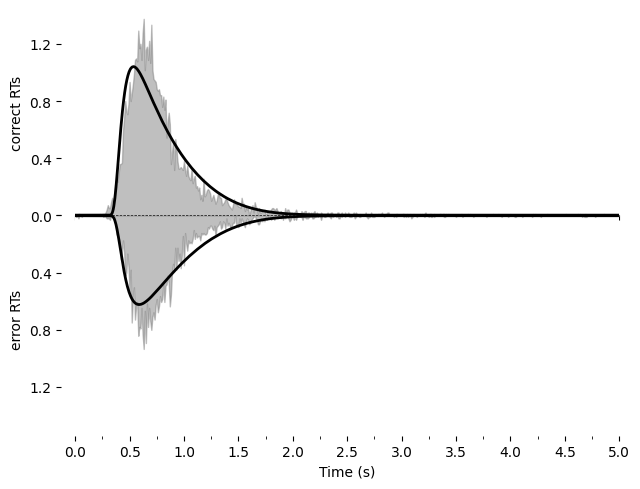

In [25]:
# Visualize model fit diagnostics to evaluate performance
%matplotlib inline
pyddm.plot.plot_fit_diagnostics(model=model_5, sample=data_sample_filtered)
plt.show()